# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_134624\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.81,1829.14,1.00,-131.89,-355.78,-487.67,-21.05
BTCUSDT,601.02,925.86,0.51,3.54,324.84,328.38,14.17
SOLUSDT,281.20,268.23,0.15,0.00,-12.97,-12.97,-0.56
JASMYUSDT,387.46,175.77,0.10,0.00,-211.68,-211.68,-9.14
ETHUSDT,250.75,172.63,0.09,0.00,-78.11,-78.11,-3.37
OMUSDT,526.32,138.81,0.08,0.00,-387.51,-387.51,-16.73
TRXUSDT,76.87,134.55,0.07,-10.72,57.68,46.96,2.03
BBUSDT,60.18,12.19,0.01,-39.73,-47.99,-87.72,-3.79
BNBUSDT,1.14,1.10,0.00,-10.61,-0.04,-10.65,-0.46
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

53

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: b48e4aac6b50adb9bec68222e99af2aa92bac818)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 8220032df5e1c8af58b47c2c7cb6d26ec74f05aa)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-06-01   -429.898146
2025-06-02   -421.754280
2025-06-03   -435.193882
2025-06-04   -455.772752
2025-06-05   -408.471425
Name: Total, Length: 256, dtype: float64

<Axes: >

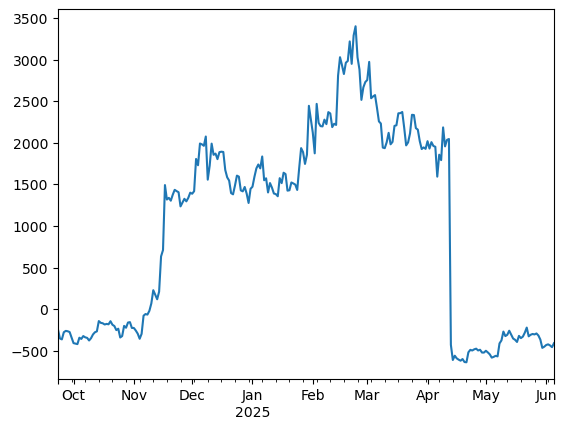

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-06-01     20.380793
2025-06-02      8.143866
2025-06-03    -13.439601
2025-06-04    -20.578871
2025-06-05     47.301328
Name: Total, Length: 256, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-402.6247508447451, -1142.8435479265506)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

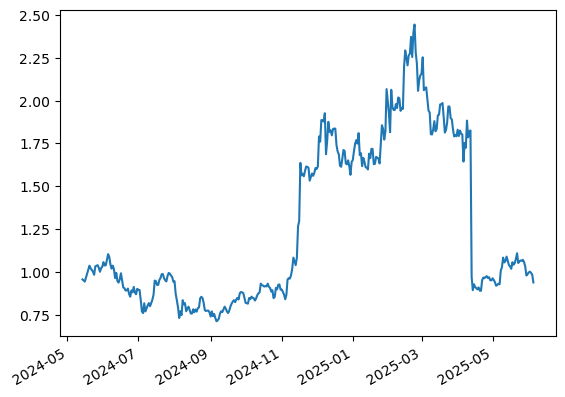

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

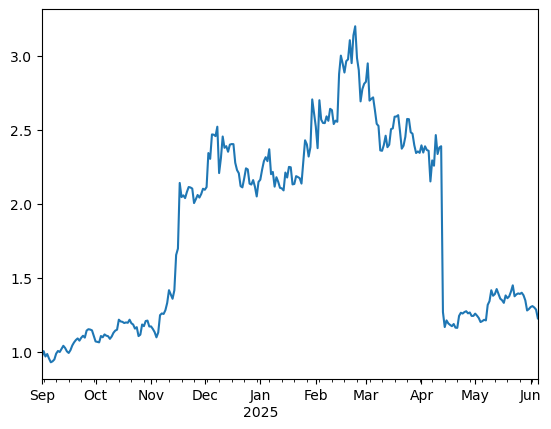

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.8046
BNBUSDT,0.0482
TRXUSDT,0.0433
AAVEUSDT,0.0200
SUIUSDT,0.0183
BTCUSDT,0.0156
PEPEUSDT,0.0154
OMUSDT,0.0152
XRPUSDT,0.0134
WBTCUSDT,0.0060


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.642858
BTCUSDT,0.300000
TRXUSDT,0.042872
OMUSDT,0.014271


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

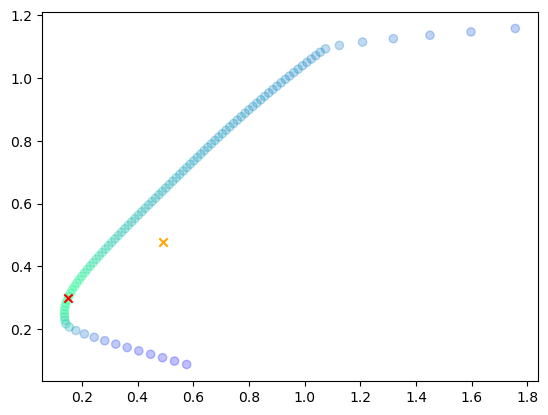

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,925.859474,0.506172,0.0308,0.475372
SOLUSDT,268.226281,0.146641,0.0000,0.146641
JASMYUSDT,175.774471,0.096097,0.0000,0.096097
ETHUSDT,172.633644,0.094380,0.0000,0.094380
OMUSDT,138.809983,0.075888,0.0080,0.067888
TRXUSDT,134.549650,0.073559,0.0244,0.049159
BBUSDT,12.188357,0.006663,0.0000,0.006663
BNBUSDT,1.098944,0.000601,0.0605,-0.059899
PEPEUSDT,0.000003,0.000000,0.0190,-0.019000
PAXGUSDT,0.000000,0.000000,0.3970,-0.397000


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.836961
BTCUSDT,0.100514
TRXUSDT,0.062525


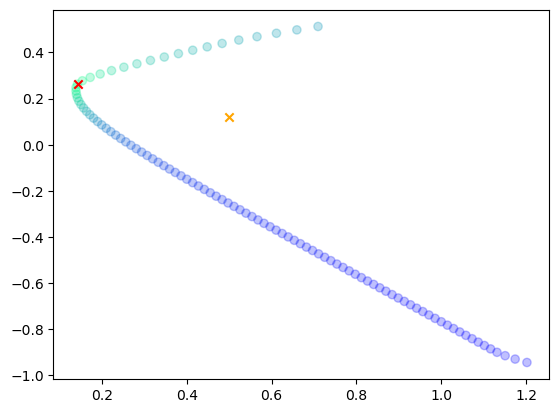

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,925.859474,0.506172,0.100514,0.405658
SOLUSDT,268.226281,0.146641,0.000000,0.146641
JASMYUSDT,175.774471,0.096097,0.000000,0.096097
ETHUSDT,172.633644,0.094380,0.000000,0.094380
OMUSDT,138.809983,0.075888,0.000000,0.075888
TRXUSDT,134.549650,0.073559,0.062525,0.011034
BBUSDT,12.188357,0.006663,0.000000,0.006663
BNBUSDT,1.098944,0.000601,0.000000,0.000601
PEPEUSDT,0.000003,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.836961,-0.836961


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

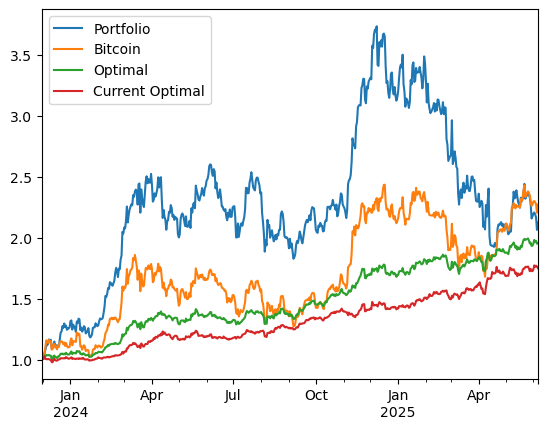

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

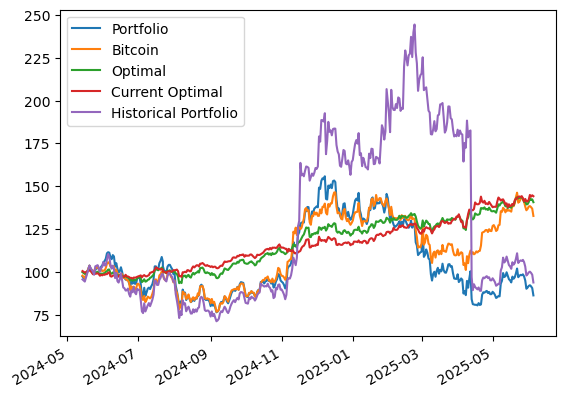

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-05-27,98.573001,142.492070,142.668076,142.958553,107.022045
2025-05-28,97.363883,140.971416,140.856232,141.030624,105.710625
2025-05-29,94.994304,138.074831,141.310410,142.571474,103.099121
2025-05-30,90.147858,135.960901,139.376101,141.227355,97.892811
2025-05-31,90.821956,136.751466,139.507602,141.061518,98.620214
2025-06-01,91.816982,138.118830,140.717894,142.193628,99.692804
2025-06-02,92.197169,138.399717,142.913078,144.900164,100.129980
2025-06-03,91.551741,137.769288,141.998375,143.893311,99.420893
2025-06-04,90.527493,136.877339,142.325289,144.714065,98.339966
2025-06-05,86.269366,132.644433,140.669287,144.166288,93.820926


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.177397
 dtype: float64,
 0.17755484567396343)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.499125
 dtype: float64,
 0.49912506896728615)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.494690
Bitcoin            0.424452
Optimal            0.177555
Current Optimal    0.139779
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5752102843543747

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

0.36709232955107146

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.24237759645209472

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.382787,0.300000,0.418805,0.595568,0.514322,0.081247
OMUSDT,-0.185648,0.014271,-0.105118,0.048033,0.019927,0.028105
PAXGUSDT,0.395828,0.642858,0.637104,0.306653,0.268134,0.038520
TRXUSDT,0.037354,0.042872,0.049209,0.049746,0.022093,0.027653
Portfolio,0.630322,1.000001,1.000000,1.000000,0.824475,0.175525


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.046622,0.100514,0.102670,0.125597,0.082264,0.043333
TRXUSDT,0.036657,0.062525,0.069209,0.121615,0.096701,0.024914
PAXGUSDT,0.349812,0.836961,0.828121,0.752788,0.718158,0.034630
Portfolio,0.433091,1.000000,1.000000,1.000000,0.897123,0.102877


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.234215,0.504950,0.758737,0.366701,0.169544,0.197157
SOLUSDT,-0.047424,0.148515,0.103767,0.181651,0.045675,0.135977
JASMYUSDT,-0.067957,0.099010,0.031875,0.164869,0.045527,0.119342
ETHUSDT,-0.032391,0.089109,0.058220,0.088900,0.011723,0.077177
OMUSDT,-0.143725,0.079208,-0.066226,0.147483,0.085574,0.061909
TRXUSDT,0.040633,0.069307,0.112851,0.033958,0.009703,0.024255
BBUSDT,-0.009146,0.009901,0.000775,0.016438,0.000568,0.015869
Portfolio,-0.025795,1.000000,1.000000,1.000000,0.368314,0.631686


In [93]:
ptf_evolution=((1+current_risk.returns).cumprod()*current_weights)
initial_weights=current_risk.inventory(current_weights)

last_nav=ptf_evolution.iloc[-1].sum()
last_row=ptf_evolution.iloc[-1]
last_weight=last_row/last_nav

perf=last_row/current_weights
perf_contrib=(perf-1)*current_weights

perf_report=pd.concat([perf_contrib,initial_weights,last_weight],axis=1)
perf_report.columns=['Performance Contribution','Initial Weights','Last Weights']
perf_report.loc['Portfolio']=perf_report.sum(axis=0)

perf_report.dropna()

,Performance Contribution,Initial Weights,Last Weights
BTCUSDT,0.234215,0.504950,0.758737
SOLUSDT,-0.047424,0.148515,0.103767
JASMYUSDT,-0.067957,0.099010,0.031875
ETHUSDT,-0.032391,0.089109,0.058220
OMUSDT,-0.143725,0.079208,-0.066226
TRXUSDT,0.040633,0.069307,0.112851
BBUSDT,-0.009146,0.009901,0.000775
Portfolio,-0.025795,1.000000,1.000000


# Value At Risk

## Historical

### Optimal Weights

In [97]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.02866459093172403, -0.03590179543165123)

### Current Weights

In [99]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0841823570128002, -0.11309735177294832)

In [100]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [101]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.025306
SOLUSDT     -0.025117
JASMYUSDT   -0.015947
ETHUSDT     -0.010242
OMUSDT      -0.004494
TRXUSDT     -0.001682
BBUSDT      -0.001365
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.084153
Name: 2025-02-24 00:00:00, dtype: float64

In [102]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.026162
SOLUSDT     -0.019161
JASMYUSDT   -0.012674
ETHUSDT     -0.009108
OMUSDT      -0.034827
TRXUSDT     -0.003697
BBUSDT      -0.001680
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.107308
dtype: float64

## Parametric

### Optimal Weights

In [105]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.026019977515893248, -0.03222744426770168)

### Current Weights

In [107]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.0731448529205187, -0.09059468516163817)

## Multivariate

### Optimal Weights

In [110]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.024792496881128, -0.02824092825807623)

### Current Weights

In [112]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.071312022646281, -0.0822789217265457)

In [113]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.026962
SOLUSDT     -0.013428
JASMYUSDT   -0.012053
ETHUSDT     -0.006480
OMUSDT      -0.010129
TRXUSDT     -0.002150
BBUSDT      -0.001240
Portfolio   -0.072441
dtype: float64

In [114]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.027875
SOLUSDT     -0.013972
JASMYUSDT   -0.011697
ETHUSDT     -0.006551
OMUSDT      -0.009181
TRXUSDT     -0.002804
BBUSDT      -0.001201
Portfolio   -0.073280
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [118]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.024666659398716522, -0.02860948250798252)

### Current Weights

In [120]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07253125472799375, -0.08391505369627879)

In [121]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [124]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.02482244311819059, -0.029293373961523286)

### Current Weights

In [126]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07460141093454055, -0.08551779687301848)

In [127]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [130]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05516431996998079, -0.06953016222811535)

### Current Weights

In [132]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.1034224317852907, -0.12524065505940365)

In [133]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [136]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [137]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.026752344013131098, -0.0305351328821531)

### Current Weights

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07500452275422227, -0.08671663284756187)

In [140]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [141]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.030480,-0.025123,-0.017895,-0.026962,-0.027351
SOLUSDT,-0.008398,-0.013458,-0.009957,-0.013428,-0.012845
JASMYUSDT,-0.006668,-0.013045,-0.009000,-0.012053,-0.011784
ETHUSDT,-0.002177,-0.006571,-0.004596,-0.006480,-0.006599
OMUSDT,-0.016465,-0.010334,-0.009220,-0.010129,-0.012539
TRXUSDT,-0.001691,-0.002795,-0.001358,-0.002150,-0.002467
BBUSDT,0.000095,-0.001323,-0.000971,-0.001240,-0.001162
Portfolio,-0.065783,-0.072649,-0.052999,-0.072441,-0.074747


In [142]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.030713,-0.025299,-0.018276,-0.027875,-0.028263
SOLUSDT,-0.007199,-0.013627,-0.009940,-0.013972,-0.013089
JASMYUSDT,-0.004382,-0.012915,-0.008952,-0.011697,-0.012785
ETHUSDT,-0.002445,-0.006662,-0.004836,-0.006551,-0.006582
OMUSDT,-0.019259,-0.011205,-0.009138,-0.009181,-0.011309
TRXUSDT,-0.002748,-0.002420,-0.001374,-0.002804,-0.002665
BBUSDT,0.000139,-0.001349,-0.001028,-0.001201,-0.001125
Portfolio,-0.066609,-0.073478,-0.053545,-0.073280,-0.075818


## VaR Violation

In [144]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.021015,-0.021509,-0.020556,-0.008094
2024-01-15,-0.021015,-0.021895,-0.020348,0.010413
2024-01-16,-0.021015,-0.021725,-0.020383,-0.001229
2024-01-17,-0.021015,-0.021448,-0.021229,-0.007440
2024-01-18,-0.021015,-0.021714,-0.021620,-0.007399
...,...,...,...,...
2025-06-02,-0.014491,-0.023035,-0.020197,0.015600
2025-06-03,-0.014491,-0.023127,-0.021525,-0.006400
2025-06-04,-0.014491,-0.021963,-0.020911,0.002302
2025-06-05,-0.014491,-0.021423,-0.021369,-0.011635


In [145]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.025952,-0.078509,-0.069384,-0.016377
2024-05-29,-0.019337,-0.076223,-0.067080,-0.009534
2024-05-30,-0.019337,-0.063549,-0.056793,0.025407
2024-05-31,-0.019337,-0.062224,-0.055012,0.007207
2024-06-01,-0.019337,-0.060868,-0.054375,0.019164
...,...,...,...,...
2025-06-02,-0.050847,-0.054268,-0.058273,0.004141
2025-06-03,-0.050847,-0.053975,-0.056573,-0.007001
2025-06-04,-0.050847,-0.053606,-0.058261,-0.011188
2025-06-05,-0.050847,-0.056246,-0.065663,-0.047037


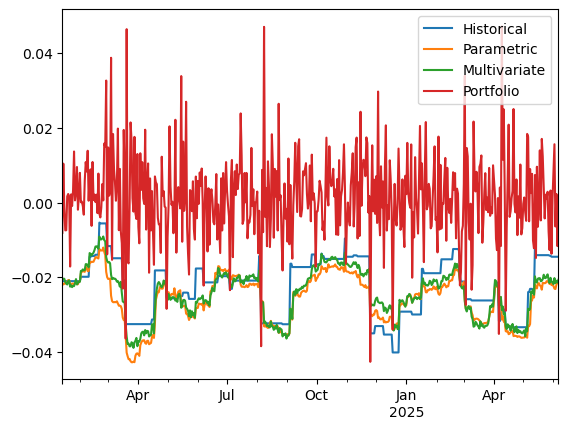

In [146]:
var_data.plot()
plt.show()

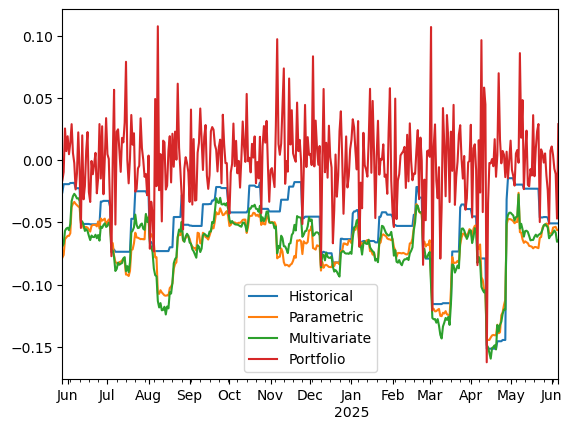

In [147]:
current_var_data.plot()
plt.show()


In [148]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031373,0.013725,0.017647
Kupiec Stat,4.270197,19.598819,14.809477
P-value,0.038786,0.00001,0.000119


In [149]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.077333,0.021333,0.016
Kupiec Stat,5.091703,8.193136,12.277756
P-value,0.024041,0.004205,0.000458


# Principal Component Analysis

## Historical PCA

In [152]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76849282, 0.09944738, 0.05613503, 0.03936925, 0.03655551])

In [153]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018354
ADAUSDT      0.019110
ALGOUSDT     0.020280
APTUSDT      0.018136
ARBUSDT      0.020665
ATOMUSDT     0.017452
AVAXUSDT     0.020142
BCHUSDT      0.015708
BNBUSDT      0.009056
BONKUSDT     0.025794
BTCUSDT      0.010051
CAKEUSDT     0.018549
CRVUSDT      0.021334
DOGEUSDT     0.019821
DOTUSDT      0.018135
ENSUSDT      0.021671
ETCUSDT      0.016791
ETHUSDT      0.014702
FDUSDUSDT    0.000071
FETUSDT      0.023609
FILUSDT      0.020019
FLOKIUSDT    0.025009
GRTUSDT      0.022170
HBARUSDT     0.018946
ICPUSDT      0.018176
IMXUSDT      0.021200
INJUSDT      0.021849
JASMYUSDT    0.022087
LDOUSDT      0.022064
LINKUSDT     0.018477
LTCUSDT      0.013709
MKRUSDT      0.014026
NEARUSDT     0.022344
NEXOUSDT     0.011469
OMUSDT       0.014586
OPUSDT       0.021120
PAXGUSDT     0.000139
PEPEUSDT     0.026033
QNTUSDT      0.015357
SANDUSDT     0.021480
SEIUSDT      0.021670
SHIBUSDT     0.018974
SOLUSDT      0.016947
STXUSDT      0.021388
SUIUSDT      0.019007
THETAUSDT 

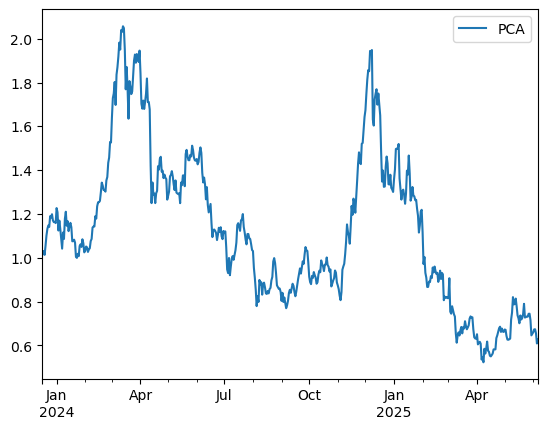

In [154]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

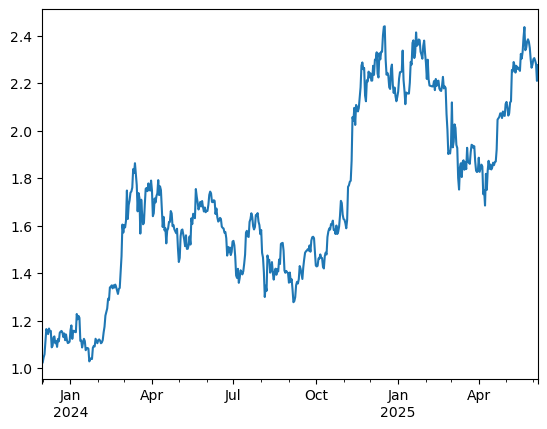

In [155]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [156]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.484698
ETHUSDT      0.484929
ETCUSDT      0.499698
DOTUSDT      0.511914
ATOMUSDT     0.535799
AVAXUSDT     0.571693
NEXOUSDT     0.575880
FILUSDT      0.579697
WBTCUSDT     0.599580
BTCUSDT      0.599914
GRTUSDT      0.605043
ARBUSDT      0.613031
LINKUSDT     0.623898
VETUSDT      0.640849
ALGOUSDT     0.653516
SOLUSDT      0.681775
THETAUSDT    0.683971
IMXUSDT      0.702546
DOGEUSDT     0.705341
dtype: float64

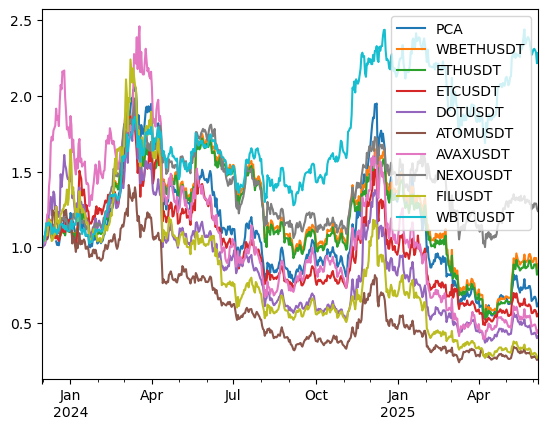

In [157]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

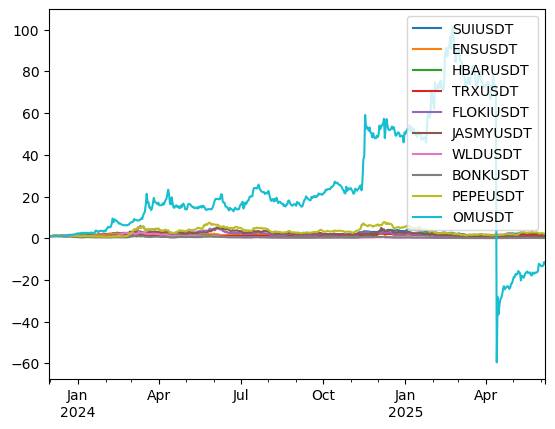

In [158]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [160]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.51044235, 0.31346941, 0.07224137, 0.0604619 , 0.04338497])

In [161]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.050308
SOLUSDT      0.091017
JASMYUSDT    0.136535
ETHUSDT      0.077405
OMUSDT       0.261288
TRXUSDT      0.035359
BBUSDT       0.162695
BNBUSDT      0.051051
PEPEUSDT     0.132919
PAXGUSDT     0.001422
Name: PC1, dtype: float64

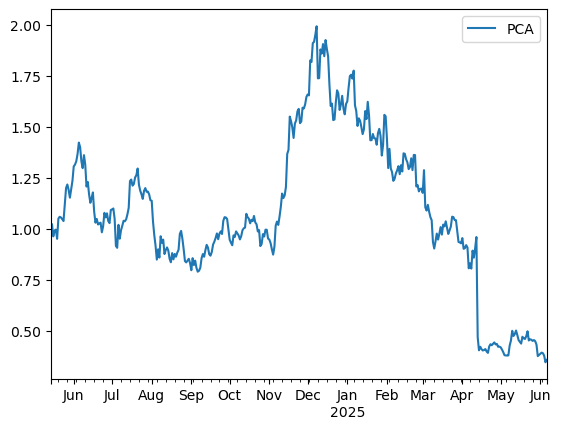

In [162]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

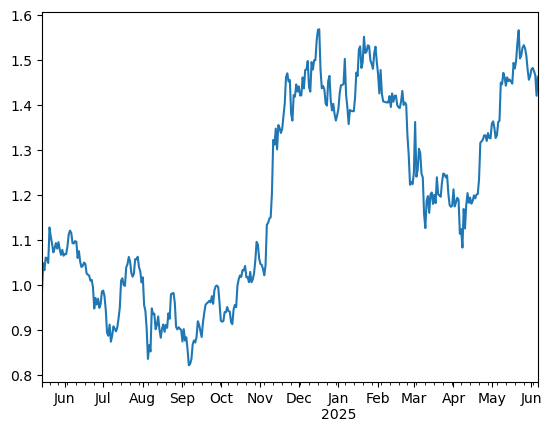

In [163]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [164]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.738855
SOLUSDT      0.770251
BTCUSDT      0.772701
BNBUSDT      0.780189
JASMYUSDT    0.987283
PAXGUSDT     1.011650
PEPEUSDT     1.025072
BBUSDT       1.035341
TRXUSDT      1.147684
dtype: float64

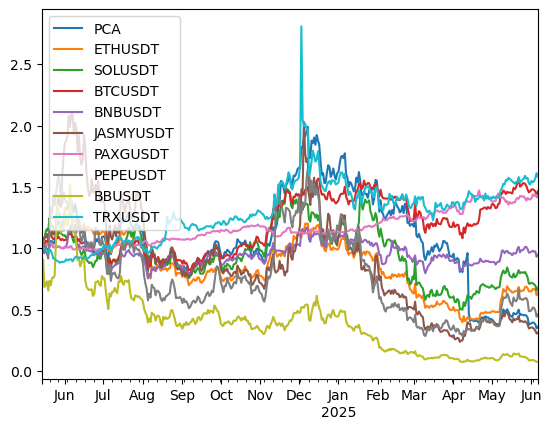

In [165]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [167]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.905225
BBUSDT       1.608303
JASMYUSDT    1.435119
SOLUSDT      1.272573
ETHUSDT      1.077030
BTCUSDT      1.000000
OMUSDT       0.966266
BNBUSDT      0.660263
TRXUSDT      0.321934
PAXGUSDT     0.030799
Name: BTCUSDT, dtype: float64

In [168]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     3.598058
BBUSDT       2.900799
OMUSDT       2.228398
JASMYUSDT    2.095057
ETHUSDT      1.955172
SOLUSDT      1.569383
BTCUSDT      1.000000
BNBUSDT      0.803582
TRXUSDT      0.219817
PAXGUSDT    -0.082656
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [171]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.214771
OMUSDT,0.191507
JASMYUSDT,0.174282
ETHUSDT,0.149498
BTCUSDT,0.122711
SOLUSDT,0.077808
TRXUSDT,0.055748
BBUSDT,-0.009085
BNBUSDT,-0.015682
PAXGUSDT,-0.020781


### Regression to PCA

In [173]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.6368934450693693

In [174]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.363663
BNBUSDT      1.224346
PCA          1.000000
ETHUSDT      0.977595
SOLUSDT      0.754279
JASMYUSDT    0.489745
PEPEUSDT     0.477481
BBUSDT       0.432863
TRXUSDT      0.292174
PAXGUSDT     0.286609
OMUSDT       0.106427
dtype: float64

In [175]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      2.086034
BNBUSDT      1.716954
TRXUSDT      1.564494
SOLUSDT      1.216958
PCA          1.000000
ETHUSDT      0.886719
JASMYUSDT    0.839207
BBUSDT       0.563310
OMUSDT       0.559800
PEPEUSDT     0.555446
PAXGUSDT    -0.711959
dtype: float64

### Correlation Matrix

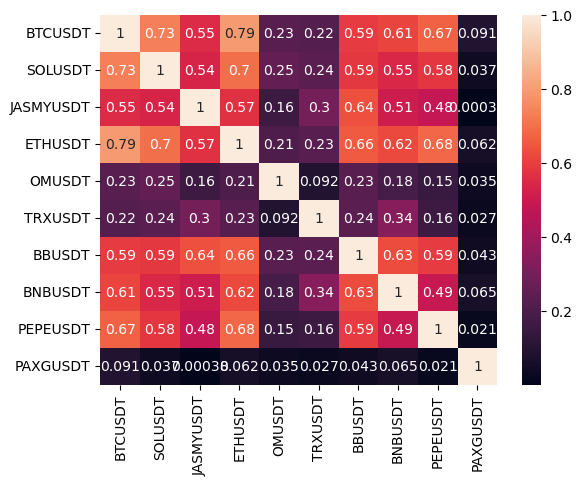

In [177]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

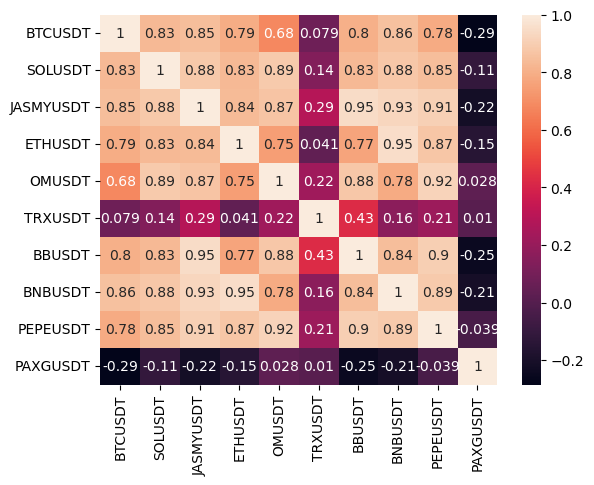

In [178]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [179]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [180]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

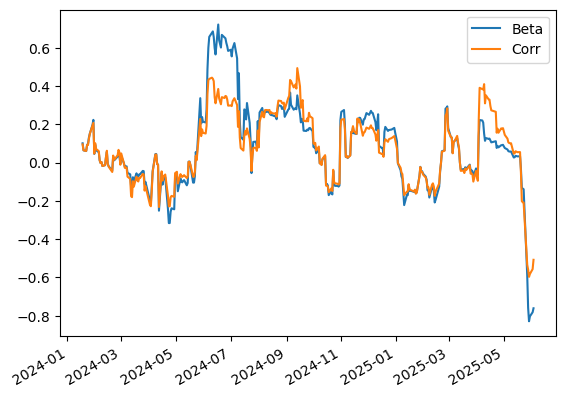

In [181]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [183]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,OMUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.483880,0.000000,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.150876,0.000000,0.626168,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.019283,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453916,0.000000,0.000000,0.000000,0.546084
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.435186,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.000000,0.166022,0.176734,0.526886,0.000000,0.000000,0.130357,0.000000


In [184]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2024-10-29,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.229399,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.038996
2024-11-28,0.000000,0.0,0.015134,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.08066,0.155890,0.000000
2024-12-28,0.430247,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-01-27,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.134442,0.000000
2025-02-26,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-03-28,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.033689,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-04-27,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.071438,...,0.091468,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
2025-05-27,0.447013,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.315917
2025-06-06,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000


In [185]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT     0.823540
MKRUSDT      0.158733
FDUSDUSDT    0.017727
AAVEUSDT     0.000000
SOLUSDT      0.000000
NEARUSDT     0.000000
Name: 2025-06-06 00:00:00, dtype: float64

In [186]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
